## 1. Install & Import Libraries

In [1]:
!pip -q install -U pip
!pip -q install --no-deps ultralytics
!pip -q install --no-deps "matplotlib>=3.8,<3.11"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.1 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import torch

print("numpy:", np.__version__, np.__file__)
print("torch:", torch.__version__, torch.__file__)

x = np.zeros((2, 3), dtype=np.float32)
t = torch.from_numpy(x)
print("from_numpy OK:", t.shape)


numpy: 1.26.4 /usr/local/lib/python3.11/dist-packages/numpy/__init__.py
torch: 2.6.0+cu124 /usr/local/lib/python3.11/dist-packages/torch/__init__.py
from_numpy OK: torch.Size([2, 3])


In [3]:
from ultralytics import YOLO
import os
import shutil
import random
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import kagglehub
import glob
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Download Dataset

In [4]:
path = kagglehub.dataset_download("jockeroika/diabetic-retinopathy")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/diabetic-retinopathy


## 3. Prepare Train & Validation Splits

In [5]:
dataset_dir = "/kaggle/input/diabetic-retinopathy"

train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"


split_ratio = 0.8

for category in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, category)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split = int(len(images) * split_ratio)
    train_imgs = images[:split]
    val_imgs = images[split:]

    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, category, img))

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, category, img))


## 4. Create YAML for YOLOv11 Classification

In [6]:
yaml_content = f"""
train: /content/train
val: /content/val

names:
  0: Healthy
  1: Mild DR
  2: Moderate DR
  3: Severe DR
  4: Proliferate DR

"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)


## 5. Train YOLOv11 Classification Model

In [7]:
model = YOLO('yolov8n-cls.pt')

model.train(
    data="/kaggle/working",
    epochs=100,
    imgsz=256,
    batch=16,
    amp=False,
    workers=0
)


Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  X : float or int or array-like
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  X : float or int or array-like


                   all      0.724          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee115cb3390>
curves: []
curves_results: []
fitness: 0.8618090450763702
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7236180901527405, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8618090450763702}
save_dir: PosixPath('/kaggle/working/runs/classify/train')
speed: {'preprocess': 0.07422530402139607, 'inference': 0.3912234120576412, 'loss': 0.0002435603011379764, 'postprocess': 0.0003888919569755818}
task: 'classify'
top1: 0.7236180901527405
top5: 1.0

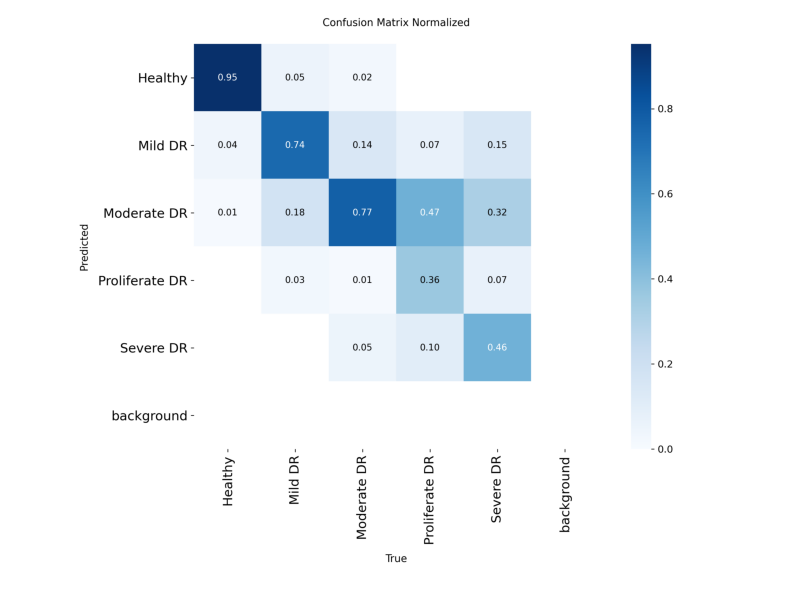

In [8]:
# Visualize confusion matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/kaggle/working/runs/classify/train/confusion_matrix_normalized.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

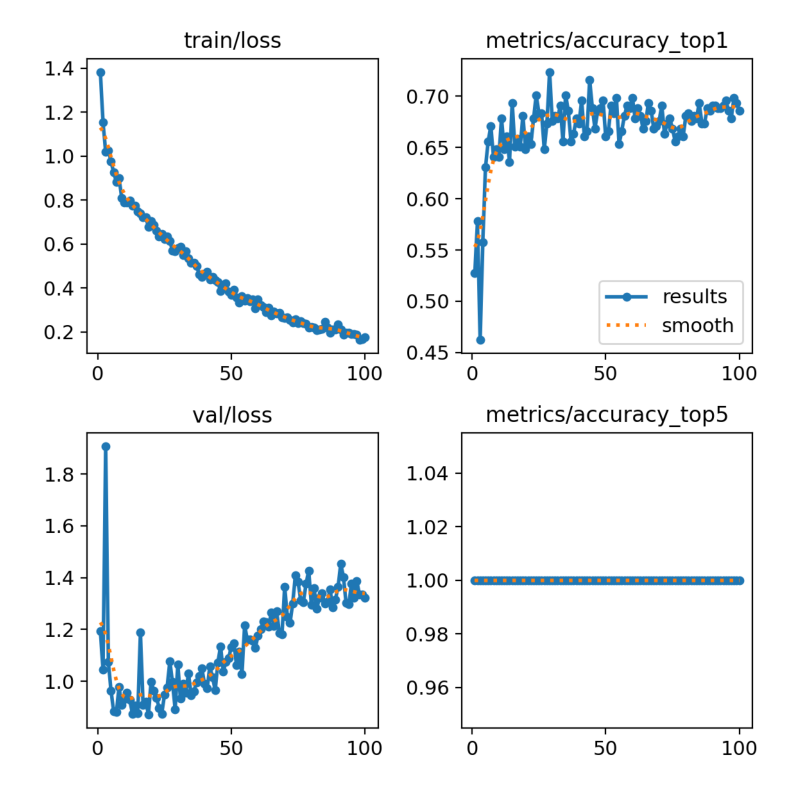

In [9]:
img = mpimg.imread('/kaggle/working/runs/classify/train/results.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()


In [10]:
model = YOLO('yolo11n-cls.pt')

model.train(
    data="/kaggle/working",
    epochs=100,
    imgsz=256,
    batch=16,
    amp=False,
    workers=0
)


Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  X : float or int or array-like
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  X : float or int or array-like


                   all      0.736          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee115b32290>
curves: []
curves_results: []
fitness: 0.8680904507637024
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7361809015274048, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8680904507637024}
save_dir: PosixPath('/kaggle/working/runs/classify/train2')
speed: {'preprocess': 0.07606494220417333, 'inference': 0.4647544924661253, 'loss': 0.00032014572958478905, 'postprocess': 0.00040084924378117016}
task: 'classify'
top1: 0.7361809015274048
top5: 1.0

## 6. View Training Results

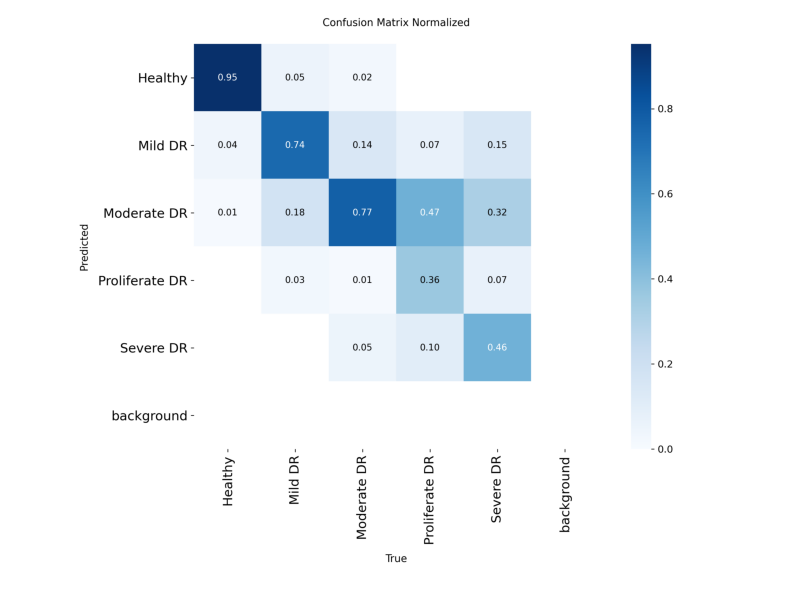

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/kaggle/working/runs/classify/train/confusion_matrix_normalized.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

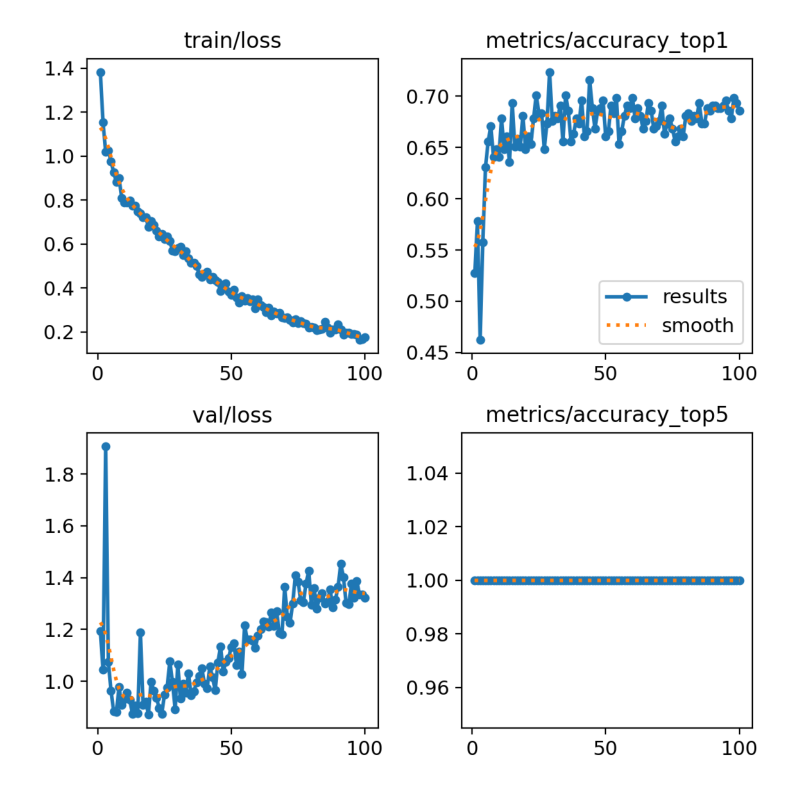

In [12]:
img = mpimg.imread('/kaggle/working/runs/classify/train/results.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()


## 7. Run Predictions on Test Images

In [13]:
def predict_class(img_path):
  results = model.predict(source=img_path)
  results[0].show()



In [14]:
path='/kaggle/working/val/Moderate DR/Moderate_DR_100.png'
predict_class(path)

FileNotFoundError: /kaggle/working/val/Moderate DR/Moderate_DR_100.png does not exist

## 8 Predict on Validation Set & Save Results

In [ ]:
model=YOLO('/kaggle/working/runs/classify/train/weights/best.pt')

In [ ]:
val_images = glob.glob("/kaggle/working/val/*/*.png") + glob.glob("/kaggle/working/val/*/*.jpg")

print(f"Found {len(val_images)} images in validation set")


results = model.predict(source=val_images, save=True, conf=0.25)


## 9 Compare Ground Truth & Prediction Side by Side

In [ ]:
gt_path = "/kaggle/working/runs/classify/train/val_batch0_labels.jpg"
pred_path = "/kaggle/working/runs/classify/train/val_batch0_pred.jpg"

gt_img = mpimg.imread(gt_path)
pred_img = mpimg.imread(pred_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gt_img)
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_img)
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
results = model.val(
    data="/kaggle/working", 
    batch=16
)

top1_acc = results.top1
top5_acc = results.top5

print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")

metrics_dict = results.results_dict
print(metrics_dict)
